In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


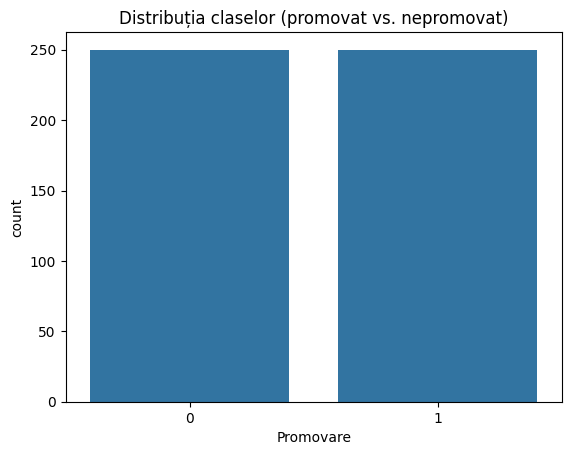

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 55 seconds.
There were 6075 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0, 0.5, 'Ore_Somn')

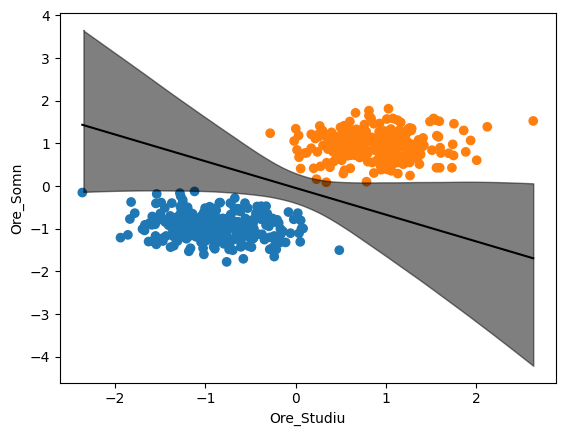

In [3]:
data = pd.read_csv("date_promovare_examen.csv")

Ore_Studiu_mean, Ore_Studiu_std = data['Ore_Studiu'].mean(), data['Ore_Studiu'].std()
Ore_Somn_mean, Ore_Somn_std = data['Ore_Somn'].mean(), data['Ore_Somn'].std()

data['Ore_Studiu'] = (data['Ore_Studiu'] - data['Ore_Studiu'].mean()) / data['Ore_Studiu'].std()
data['Ore_Somn'] = (data['Ore_Somn'] - data['Ore_Somn'].mean()) / data['Ore_Somn'].std()

x_n = ['Ore_Studiu', 'Ore_Somn']
x_1 = data[x_n].values
y_data = np.array(data['Promovare'])

sns.countplot(x='Promovare', data=data)
plt.title("Distribuția claselor (promovat vs. nepromovat)")
plt.show()

with pm.Model() as model2:
  beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=len(x_n))
  mu = beta_0 + pm.math.dot(x_1, beta)

  theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

  bd = pm.Deterministic('bd', -beta_0/beta[1] - beta[0]/beta[1] * x_1[:,0])
  yl = pm.Bernoulli('yl', p=theta, observed=y_data)

  idata_1 = pm.sample(2000, return_inferencedata=True)

idx = np.argsort(x_1[:,0])
bd = idata_1.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_data])

plt.plot(x_1[:,0][idx], bd, color='k')
az.plot_hdi(x_1[:,0], idata_1.posterior['bd'], color='k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])



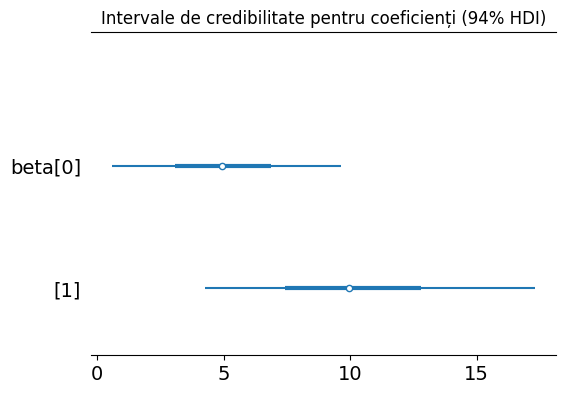

In [4]:
az.plot_forest(idata_1, var_names=["beta"], combined=True, hdi_prob=0.94)
plt.title("Intervale de credibilitate pentru coeficienți (94% HDI)")
plt.show()